<div id="title"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:50px;text-align:center">U-Net Multiclasses Training</h1></div>

Projeto desenvolvido usando a rede de segmentação U-NET, biblioteca Keras e Tensorflow.
O Road Mapper DNN tem como objetivo gerar mapas de estrada com segmentação das faixas de sinalização utilizada pelos veículos, tendo como entrada mapas de remissão gerados pelo LIDAR - sensor laser que faz parte do sistema de carros autônomos como o ASTRO da Lume Robotics.


Input | Output
------|--------
![](https://github.com/LCAD-UFES/carmen_lcad/blob/master/src/road_mapper/data/i7705600_-338380.png?raw=true)|![](https://github.com/LCAD-UFES/carmen_lcad/blob/master/src/road_mapper/data/r7705600_-338380_map_1_6.png?raw=true)



## Tabela de Conteúdos

  **<font size="2"><a href="#chap1">1. Instalar Pacotes</a></font>**
  **<br><font size="2"><a href="#chap2">2. Configurações Iniciais</a></font>**
  **<br><font size="2"><a href="#chap3">3. Tratamento de Dados</a></font>**
  **<br><font size="2"><a href="#chap4">4. Compilação e Treinamento da Rede</a></font>**
  **<br><font size="2"><a href="#chap5">5. Analisando os Resultados</a></font>**
  **<br><font size="2"><a href="#chap6">6. Realizando Testes</a></font>**

##Instalar Pacotes


In [ ]:
%pip install opencv-python
%pip install tensorflow
%pip install numpy
%pip install tqdm
%pip install scikit-image
%pip install scikit-learn
%pip install matplotlib


In [ ]:
%pip install kaggle

## Configurações Iniciais


In [ ]:
# Importando as principais bibliotecas

import os
import glob

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
import tensorflow as tf




In [ ]:
# Conexão com o drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# rode essa célula apenas para criar uma pasta no root

!kaggle datasets download -d ludmiladias/road-mapper-6classes


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
# verificando se a pasta foi criada
!find . -iname ".kaggle"

In [ ]:
!ls

drive  sample_data


In [ ]:
# move o arquivo kaggle.json importado
!cp /content/drive/MyDrive/ROAD_MAPPER_DNN/kaggle.json ../root/.kaggle/kaggle.json

In [ ]:
# Importar dataset do Kaggle

!kaggle datasets download -d ludmiladias/road-mapper-6classes
!unzip road-mapper-6classes.zip

 99% 1.49G/1.50G [00:22<00:00, 71.9MB/s]
100% 1.50G/1.50G [00:22<00:00, 72.3MB/s]
Archive:  road-mapper-6classes.zip
  inflating: dataset6classes.csv     
  inflating: dataset6classes_teste.csv  
  inflating: dataset6classes_teste_mixed.csv  


In [ ]:
# Definição de variaveis iniciais

SIZE_X = 128
SIZE_Y = 128

TRAIN_PATH = 'DATASET/treino/'
TEST_PATH_HIGHWAY = 'DATASET/teste/highway/'
TEST_PATH_UFES = 'DATASET/teste/ufes/'

IMG_CHANNELS = 1
NUM_CLASSES = 6 # Número de classes

## Tratamento de Dados

Pule essa etapa se você já tiver seus dados prontos em um CSV.

**<font color="#62909d" size="5">Importando os arquivos</font>**


In [ ]:
# Obter uma lista das subpastas
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids_hw = next(os.walk(TEST_PATH_HIGHWAY))[1]
test_ids_uf = next(os.walk(TEST_PATH_UFES))[1]

In [ ]:
X_train = np.zeros((len(train_ids), SIZE_Y, SIZE_X, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), SIZE_Y, SIZE_X), dtype = np.uint8)


X_test = np.zeros((len(test_ids_hw), SIZE_Y, SIZE_X, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids_hw), SIZE_Y, SIZE_X), dtype = np.uint8)


In [ ]:
# CARREGA IMAGENS PARA ARRAY DE TREINO
def imgs_to_array(TRAIN_PATH, type_data):
    if type_data == 'I':

        for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):

            path = TRAIN_PATH + id_

            # Read the image and keep the first IMG_CHANNELS channels
            img = imread(path + '/images/i' + id_ + '.png', 0)

            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            img = np.expand_dims(img, axis=2)

            # Resize the image to SIZE_Y x SIZE_X while keeping the pixel values (mode='constant')
            img = resize(img, (SIZE_Y, SIZE_X), mode='constant', preserve_range=True)

            # Store the processed image into the X_train array at index n
            X_train[n]=img

        return X_train

    elif type_data == 'M':
    # Loop through all train_ids
        for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):

            path = TRAIN_PATH + id_

            # Read the mask file
            mask = imread(path + '/masks/r' + id_ + '.png', 0)

            mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)


            # Store the processed mask into the Y_train array at index n
            Y_train[n] = mask

        return Y_train

    return []

In [ ]:
image_dataset = imgs_to_array(TRAIN_PATH, type_data='I') # 'I' - Imagens de input
mask_dataset = imgs_to_array(TRAIN_PATH, type_data='M') # 'M' - Masks do Ground Truth

In [ ]:
# SALVAR ARRAYS DAS IMAGENS

import pickle
try:
    arquivo = open("bin/image_dataset.bin", "wb")
    pickle.dump(image_dataset, arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treino.")

try:
    arquivo = open("bin/mask_dataset.bin", "wb")
    pickle.dump(mask_dataset, arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo teste.")

In [ ]:
#  LOAD DOS ARRAYS SALVOS

import pickle

try:
    arquivo = open("/kaggle/input/road-mapper-dataset/image_dataset.bin", "rb")
    image_dataset = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinox.")

try:
    arquivo = open("/kaggle/input/road-mapper-dataset/mask_dataset.bin", "rb")
    mask_dataset = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinoy.")

In [ ]:
#  LOAD DOS ARRAYS SALVOS

import pickle

try:
    arquivo = open("/content/x_train_50k.bin", "rb")
    X_train = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinox.")

try:
    arquivo = open("/content/y_train_50k.bin", "rb")
    y_train = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinoy.")

**<font color="#62909d" size="5">Encoding</font>**


In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

In [ ]:
# Realizar o Label Encoder
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = image_dataset.shape
train_masks_reshaped = image_dataset.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
print(train_masks_input.shape)

In [ ]:
#Dividir dados de treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, train_masks_input, test_size = 0.2, random_state = 42)

## Gerando pesos balanceados

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.utils import normalize
import pickle
import json

In [ ]:
from sklearn.preprocessing import LabelEncoder
def labelencoder(train_masks):
    labelencoder = LabelEncoder()
    n, h, w, c= train_masks.shape
    train_masks_reshaped = train_masks.reshape(-1,1)
    train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
    train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w, c)

#     print("encoder concluido")
#     return np.expand_dims(train_masks_encoded_original_shape, axis=3)
    return train_masks_encoded_original_shape

In [ ]:
# importar bin e fazer processo de normalização com x e expand dims com y
def process_data(x, y):

    #return (normalize(x, axis=1), labelencoder(y))
    return (x, labelencoder(y))

def load_csv(Train_df, batch_size, idx=0):

    df = pd.read_csv(
                  Train_df, skiprows=idx*batch_size,
                  nrows=batch_size)

    x = []
    y = []

    for i in range(0, batch_size):
        try:
            x.append(json.loads(df.iloc[i,0]))
            y.append(json.loads(df.iloc[i,1]))
        except:
            print("erro ao ler linha")
            continue

    y = np.asarray(y)

#     return (np.asarray(x), y.expand_dims(axis=1))
    return y


def clean(x, y, ex):
    if ex<8000:
        tst = np.zeros((128,128,1), dtype = np.uint8)
        for idx in range(y.shape[0]-1, -1, -1):
            if np.all(y[idx] == tst):
                y = ea
                x = np.delete(x, idx, axis=0)

    save_csv('dataset_treino_cleaned_50k.csv', x, y)

def save_csv(nome_arq, X, Y):
    data = {'X_input': [X.tolist()], 'Y_output': [Y.tolist()]}
    df = pd.DataFrame(data)
    df.to_csv(nome_arq, index=False, header=False, mode="a")

def classes_in_array(dado):
    quant_class = np.zeros(17, dtype = np.uint8)
    for lin in dado:
        for v in lin:
            for i in range(17):
                if v[0]==i:
                    quant_class[i]+=1
                    break
    return quant_class

def plot_classes(dado, n_classe):
    img = np.zeros((1,128,128,1), dtype = np.uint8)
    for lin, idx in zip(dado, range(128)):
        for v, idy in zip(lin, range(128)):
            if v[0]==n_classe:
                img[0][idx][idy][0] = 255
    return img

def plot_new_classes(dado, classes):
    img = np.zeros((1,128,128,1), dtype = np.uint8)
    for lin, idx in zip(dado, range(128)):
        for v, idy in zip(lin, range(128)):
            for cs,new in zip(classes, range(len(classes))):
                if v[0] in cs:
                    img[0][idx][idy][0] = new
    return img

def get_new_classes(dado, classes):
    for lin, idx in zip(dado, range(128)):
        for v, idy in zip(lin, range(128)):
            for cs,new in zip(classes, range(len(classes))):
                if v[0] in cs:
                    dado[0][idx][idy][0] = new
    return dado

def save_idx(namearq, file):
    try:
        arquivo = open(namearq, "wb")
        pickle.dump(file, arquivo)
        arquivo.close()
    except:
        print("Problemas ao salvar arquivo.")

def update_classes(classes, quant_classes):
    for i in range(len(quant_classes)):
        classes[i]+=quant_classes[i]

def classes_dic():
    dic = {}
    for i in range(17):
        dic[i] = 0

    return dic

In [ ]:

# GET DADOS P/ CALCULAR PESOS
classes = classes_dic()
tam_lote = 3584
total = 39424
n_lotes = total//tam_lote
y = []
Train_df = '/content/dataset6classes.csv'

for n in tqdm(range(0, n_lotes), desc="Processing..."):
    dadoy = load_csv(Train_df, tam_lote, idx=n)
    for dado in dadoy: # dado = array de uma imagem
      quant_classes = classes_in_array(dado)
      update_classes(classes, quant_classes)
    print(classes)

print('concluido')



Processing...:   9%|▉         | 1/11 [04:12<42:06, 252.67s/it]

{0: 505318, 1: 408532, 2: 452325, 3: 399876, 4: 377909, 5: 500520, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0}


Processing...:  18%|█▊        | 2/11 [08:24<37:47, 251.94s/it]

{0: 1010332, 1: 811133, 2: 905159, 3: 801112, 4: 764742, 5: 1003650, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0}


Processing...:  27%|██▋       | 3/11 [12:28<33:07, 248.43s/it]

{0: 1513958, 1: 1212696, 2: 1357444, 3: 1206201, 4: 1154672, 5: 1506645, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0}


Processing...:  36%|███▋      | 4/11 [16:45<29:22, 251.73s/it]

{0: 2016983, 1: 1612946, 2: 1810688, 3: 1609228, 4: 1537290, 5: 2009217, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0}


Processing...:  45%|████▌     | 5/11 [20:50<24:57, 249.54s/it]

{0: 2534999, 1: 2014591, 2: 2268826, 3: 2008138, 4: 1910883, 5: 2517987, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0}


Processing...:  55%|█████▍    | 6/11 [25:04<20:53, 250.80s/it]

{0: 3053140, 1: 2419057, 2: 2725366, 3: 2407801, 4: 2288089, 5: 3018227, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0}


Processing...:  64%|██████▎   | 7/11 [29:16<16:45, 251.48s/it]

{0: 3575559, 1: 2826146, 2: 3183460, 3: 2807879, 4: 2672414, 5: 3521934, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0}


Processing...:  73%|███████▎  | 8/11 [33:29<12:35, 251.79s/it]

{0: 4088943, 1: 3224058, 2: 3641961, 3: 3209384, 4: 3061478, 5: 4026528, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0}


Processing...:  82%|████████▏ | 9/11 [37:47<08:27, 253.79s/it]

{0: 4604059, 1: 3634782, 2: 4101772, 3: 3612454, 4: 3442967, 5: 4526398, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0}


Processing...:  91%|█████████ | 10/11 [42:01<04:13, 253.79s/it]

{0: 5118769, 1: 4037902, 2: 4563822, 3: 4018010, 4: 3819184, 5: 5025097, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0}


Processing...: 100%|██████████| 11/11 [46:21<00:00, 252.87s/it]

{0: 5637283, 1: 4437575, 2: 5025976, 3: 4420648, 4: 4194830, 5: 5531176, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0}
concluido


In [ ]:
for i in range(6,17):
  classes.pop(i)

In [ ]:
# Calculo dos pesos das classes
n_classes = 6
class_weights = []

for i in range(n_classes):
  valor_classe = (total*128*128)/(n_classes*classes[i])
  class_weights.append(valor_classe)

print("Class weights are...:", class_weights)

Class weights are...: [19.09675328818274, 24.259601847104932, 21.419482040237888, 24.352493721885722, 25.66344826051751, 19.46309476803245]


In [ ]:
import json
def save_file_json(name, data):

  with open(name, 'w') as f:
      json.dump(data, f)



In [ ]:

save_file_json('/content/drive/MyDrive/Lume/road_mapper_dnn/weights_6classes.json', class_weights)

## Gerando Dataset com Novas Classes

In [ ]:
import json
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from keras.utils import normalize


def test_data_generator(pos_ini, mode):
  test_df = "/content/train_cleaned.csv"

  df = pd.read_csv(
                    test_df, skiprows=pos_ini, nrows=1)
  n_classes=6
  x = []
  y = []
  for i in range(0, len(df)):
      x.append(json.loads(df.iloc[i,0]))
      y.append(json.loads(df.iloc[i,1]))

  if mode=='x':
    x = normalize(x, axis=1)
    return np.asarray(x)
  elif mode=='y':
    return np.asarray(y)

  return None

In [ ]:
# NEW CSV classes
import random
random.seed(42)
num_imgs = 49622


classes = [[0], [1,2,3,4],[5, 6],[7,8,9, 10],[11, 12],[13,14,15,16]]

for i in range(num_imgs):
    Y_test = test_data_generator(i, 'y')
    X_test = test_data_generator(i, 'x')
    newY = get_new_classes(Y_test[0],classes)
    save_csv('dataset6classes.csv', X_test[0], newY[0])


print('concluido')

**<font color="#62909d" size="5">Salvar arquivo como CSV</font>**


In [ ]:
import csv
import pandas as pd

def salvar_csv(X, Y, file_name):
    # Criar um DataFrame com os arrays
    data = {'X_input': X.tolist(), 'Y_output': Y.tolist()}
    df = pd.DataFrame(data)
    df.to_csv(file_name, index=False, mode="a")

In [ ]:
# Para salvar arquivo grande em partes
for i in range(0,1):
    print(i)
    salvar_csv(X_train[(i*100):((i+1)*100)], y_train[(i*100):((i+1)*100)], 'train_data50.csv') # arquivo de treino

0


In [ ]:
for j in range(0,2):
    print(j)
    salvar_csv(X_test[(j*5000):((j+1)*5000)], Y_test[(j*5000):((j+1)*5000)], 'test_data50.csv') # arquivo de teste

In [ ]:
# Link para download dos arquivos
from IPython.display import FileLink, FileLinks
display(FileLink('train_data.csv'))
display(FileLink('test_data.csv'))


## Configurações do Modelo

**<font color="#62909d" size="5">Modelo 1 - Original U-NET</font>**

In [ ]:
# Criando uma função para um convolution block
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu",
                               kernel_initializer="he_normal", padding="same")(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu",
                               kernel_initializer="he_normal", padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    return x

# Criando a função para o expanding path
def upsample_block(inputs, conv_prev, num_filters):
    up = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    concat = tf.keras.layers.concatenate([up, conv_prev])
    conv = conv_block(concat, num_filters)
    return conv


In [ ]:
import tensorflow as tf

# Inputs
inputs = tf.keras.layers.Input((SIZE_X, SIZE_Y, IMG_CHANNELS))

# Normalização
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs)

# Contraction path
c1 = conv_block(s, 16)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256)

# Expansive path
c6 = upsample_block(c5, c4, 128)
c7 = upsample_block(c6, c3, 64)
c8 = upsample_block(c7, c2, 32)
c9 = upsample_block(c8, c1, 16)

# Output layer

outputs = tf.keras.layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax')(c9)

In [ ]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs], name="U-Net")
# Compilação
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.save('multiclass_road_mapper')
model.summary()


**<font color="#62909d" size="5">Modelo 2 - Custom U-NET</font>**
<br>**Modelo sendo utilizado no momento**

In [ ]:
!pip install keras_unet

In [ ]:
from keras_unet.models import custom_unet

def get_customunet():
  model = custom_unet(
      input_shape=(128, 128, 1),
      use_batch_norm=True,
      num_classes=6,
      filters=16,
      dropout=0.2,
      output_activation='softmax')
  print(model.summary())
  return model

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------



**<font color="#62909d" size="5">Compilando o Modelo</font>**

In [ ]:
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf

epsilon = 1e-5
smooth = 1


def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [ ]:
from keras import backend as K

def IoU_coef(y_true, y_pred):
  T = K.flatten(y_true)
  P = K.flatten(y_pred)

  intersection = K.sum(T *P)
  IoU = (intersection + 1.0) / (K.sum(T) + K.sum(P) - intersection +1.0)
  return IoU

def IoU_loss(y_true, y_pred):
  return -IoU_coef(y_true, y_pred)

In [ ]:
from keras import backend as K

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# LOSS DISPONÍVEIS PARA USO
# IoU_loss (X)
# categorical_focal_crossentropy (v)
# tversky_loss (X)

# Carregando o modelo
from keras.models import load_model
from sklearn.utils import class_weight

def load_new_model(nomeModelo):
    model = load_model(nomeModelo)
    # model=get_customunet()
    model.load_weights(nomeModelo)
    # nome_salvar_modelo = '/content/drive/MyDrive/ROAD_MAPPER_DNN/TREINOS/new_train_road_mapper_0611_2.keras'

    #optimizer=tfa.optimizers.RectifiedAdam(lr=1e-3)
    # loss = tf.keras.losses.SparseCategoricalCrossentropy()

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    tf.keras.losses.CategoricalFocalCrossentropy(
      alpha=0.25,
      gamma=2.0,
      from_logits=False,
      label_smoothing=0.0,
      axis=-1,
      reduction= tf.keras.losses.Reduction.AUTO,
      name='categorical_focal_crossentropy'
)

    model.compile(optimizer=opt, loss='categorical_focal_crossentropy', metrics=['categorical_accuracy', IoU_coef, f1_score])
    # model.save(nome_salvar_modelo)

    return model

In [ ]:
# Compilar e Salvar modelo
def get_model():
  model=get_customunet()

  # nome_salvar_modelo = '/content/drive/MyDrive/ROAD_MAPPER_DNN/TREINOS/new_train_road_mapper_0611.keras'

  opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

  tf.keras.losses.CategoricalFocalCrossentropy(
      alpha=0.25,
      gamma=2.0,
      from_logits=False,
      label_smoothing=0.0,
      axis=-1,
      reduction= tf.keras.losses.Reduction.AUTO,
      name='categorical_focal_crossentropy'
  )

  iou = tf.keras.metrics.MeanIoU(num_classes=6)
  model.compile(optimizer=opt, loss='categorical_focal_crossentropy', metrics=['categorical_accuracy', iou])
  # model.save(nome_salvar_modelo)
  return model

In [ ]:
# # Compilar e Salvar modelo
# nome_salvar_modelo = '/content/drive/MyDrive/Lume/road_mapper_dnn/multiclass_road_mapper_customunet_10'

# opt = tf.keras.optimizers.Adam(learning_rate=0.0015)
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# model.save(nome_salvar_modelo)

## Batch Generator

In [ ]:
import requests
import time

def avoid_inactivity():
    try:
        requests.get('https://www.google.com')
        return False
    except:
        return True

In [ ]:
from tensorflow.keras.utils import to_categorical
import json
from keras.utils import normalize

import pandas as pd

def batch_generator(Train_df,batch_size,
                    steps, skiprows):
    idx=1
    while True:
        yield load_data(Train_df,idx-1,batch_size, skiprows[idx-1])## Yields data
        if idx<steps:
            idx+=1
        else:
            idx=1
        avoid_inactivity()

def load_data(Train_df,idx,
              batch_size, sr):
    n_classes = 6

    df = pd.read_csv(
                  Train_df, skiprows=sr,
                  nrows=batch_size)

    x = []
    y = []

    for i in range(0, batch_size):
        x.append(json.loads(df.iloc[i,0]))
        y.append(json.loads(df.iloc[i,1]))

    y = np.asarray(y)
    x = np.asarray(x)

    train_masks_cat = to_categorical(y, num_classes=n_classes)
    y = train_masks_cat.reshape((y.shape[0], y.shape[1], y.shape[2], n_classes))
    x = normalize(x, axis=1)


    return (x, y)

In [ ]:
def getsteps(total_dados, batch_size):
  print((total_dados//batch_size)*batch_size)
  return total_dados//batch_size

In [ ]:
import numpy as np
import random

from keras.models import Sequential
from keras.layers import Dense, Activation
quant_train = 39424
quant_test = 9984
batch_size = 256
nb_epoch = 50
skiprows = []

# Objetos gerados para treino e validação
steps_per_epoch=np.ceil(getsteps(quant_train,batch_size))
validation_steps=np.ceil(getsteps(quant_test,batch_size))

total_dados = quant_test + quant_train
for sr in range(0, total_dados, batch_size):
  skiprows.append(sr)

# random.shuffle(skiprows)

my_training_batch_generator = batch_generator('/content/dataset6classes.csv', batch_size,steps_per_epoch, skiprows[0:int(steps_per_epoch)])##
my_validation_batch_generator = batch_generator('/content/dataset6classes.csv', batch_size,validation_steps, skiprows[int(steps_per_epoch):])##

39424
9984


## Treinamento padrão

In [ ]:
# Model Checkpoint e Early Stopping
# https://github.com/luddias/DeepLearning-About/blob/main/checkpointing.md
# https://github.com/luddias/DeepLearning-About/blob/main/early_stoping.md

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
def get_checkpoint(filepath):
  checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
  es = EarlyStopping(monitor='val_categorical_accuracy', patience=5)
  reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, mode='max')
  return [checkpoint, es, reduce_lr]


In [ ]:
callbacks_list = get_checkpoint('/content/drive/MyDrive/Lume/road_mapper_dnn/T_121223_6classes/model_checkpoint_121223')

In [ ]:
import json

def load_file_json(name):
    with open(name, 'r') as f:
        return json.load(f)


In [ ]:
lw = load_file_json('/content/drive/MyDrive/Lume/road_mapper_dnn/weights_6classes.json')
class_weights = {}

for i in range(len(lw)):
  class_weights[i] = lw[i]

class_weights

{0: 19.09675328818274,
 1: 24.259601847104932,
 2: 21.419482040237888,
 3: 24.352493721885722,
 4: 25.66344826051751,
 5: 19.46309476803245}

In [ ]:
import os
import json

from keras.models import load_model

import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # multi_worker_model= get_model()
    # multi_worker_model= load_model('/content/drive/MyDrive/Lume/road_mapper_dnn/T_111223_6classes/kfold_checkpoint_model_0612', compile=True)
    multi_worker_model= load_new_model('/content/drive/MyDrive/Lume/road_mapper_dnn/T_111223_6classes/checkpoint_model_111223')


In [ ]:
# Treinamento
import tensorflow as tf
import pandas as pd

with strategy.scope():
    history= multi_worker_model.fit(my_training_batch_generator,
                    epochs=nb_epoch,
                    steps_per_epoch=steps_per_epoch,
                    # class_weight=class_weights_iou,
                    verbose=1,
                    validation_data=my_validation_batch_generator,
                    validation_steps=validation_steps,
                    callbacks=[callbacks_list])

Epoch 1/50
154/154 [==============================] - ETA: 0s - loss: 0.0104 - categorical_accuracy: 0.9434 - IoU_coef: 0.7759 - f1_score: 0.9424 
Epoch 1: val_categorical_accuracy improved from -inf to 0.93689, saving model to /content/drive/MyDrive/Lume/road_mapper_dnn/T_121223_6classes/model_checkpoint_121223
154/154 [==============================] - 3502s 22s/step - loss: 0.0104 - categorical_accuracy: 0.9434 - IoU_coef: 0.7759 - f1_score: 0.9424 - val_loss: 0.0123 - val_categorical_accuracy: 0.9369 - val_IoU_coef: 0.7606 - val_f1_score: 0.9359 - lr: 0.0010
Epoch 2/50
154/154 [==============================] - ETA: 0s - loss: 0.0102 - categorical_accuracy: 0.9443 - IoU_coef: 0.7759 - f1_score: 0.9432 
Epoch 2: val_categorical_accuracy improved from 0.93689 to 0.93714, saving model to /content/drive/MyDrive/Lume/road_mapper_dnn/T_121223_6classes/model_checkpoint_121223
154/154 [==============================] - 3487s 23s/step - loss: 0.0102 - categorical_accuracy: 0.9443 - IoU_coef

In [ ]:
# Salvando o mode
model.save('multiclass_road_mapper_custom_0012_2_10.keras')


In [ ]:
history =  historico_combinado = {
    'loss': [
        3.0638, 1.2885, 0.9570, 0.7749, 0.6565, 0.5813, 0.5248, 0.4812, 0.4476,
        0.8256, 0.7174, 0.6825, 0.6555, 0.6274, 0.6047, 0.5894, 0.5777, 0.5665,
        0.4933, 0.4629, 0.4534, 0.4249, 0.4150, 0.4068, 0.4020, 0.3980, 0.3918,
        0.2452, 0.2418, 0.2388, 0.2369, 0.2351, 0.2339, 0.2272, 0.2232, 0.2217,
        0.0097, 0.0097, 0.0096, 0.0096, 0.0095, 0.0095, 0.0094, 0.0094, 0.0094, 0.0093, 0.0092, 0.0091
    ],
    'categorical_accuracy': [
        0.7128, 0.8408, 0.8656, 0.8816, 0.8931, 0.9007, 0.9065, 0.9112, 0.9149,
        0.8982, 0.9078, 0.9107, 0.9130, 0.9155, 0.9176, 0.9189, 0.9198, 0.9208,
        0.9242, 0.9274, 0.9284, 0.9317, 0.9328, 0.9338, 0.9344, 0.9348, 0.9355,
        0.9421, 0.9427, 0.9432, 0.9434, 0.9436, 0.9438, 0.9450, 0.9456, 0.9458,
        0.9459, 0.9461, 0.9463, 0.9465, 0.9467, 0.9469, 0.9471, 0.9471, 0.9473, 0.9479, 0.9481, 0.9483
    ],
    'val_loss': [
        0.1653, 0.1138, 0.0646, 0.0382, 0.0311, 0.0279, 0.0250, 0.0238, 0.0219,
        0.0245, 0.0238, 0.0227, 0.0217, 0.0217, 0.0207, 0.0211, 0.0195, 0.0187,
        0.0175, 0.0179, 0.0176, 0.0159, 0.0149, 0.0147, 0.0150, 0.0146, 0.0148,
        0.0129, 0.0126, 0.0127, 0.0124, 0.0129, 0.0124, 0.0119, 0.0116, 0.0118,
        0.0116, 0.0116, 0.0116, 0.0115, 0.0115, 0.0115, 0.0113, 0.0113, 0.0113, 0.0111, 0.0111, 0.0110
    ],
    'val_categorical_accuracy': [
        0.7022, 0.7671, 0.8281, 0.8693, 0.8857, 0.8932, 0.9004, 0.9016, 0.9073,
        0.9001, 0.9020, 0.9047, 0.9054, 0.9049, 0.9084, 0.9065, 0.9107, 0.9129,
        0.9176, 0.9154, 0.9168, 0.9229, 0.9263, 0.9264, 0.9259, 0.9269, 0.9264,
        0.9347, 0.9359, 0.9354, 0.9365, 0.9346, 0.9363, 0.9385, 0.9396, 0.9387,
        0.9394, 0.9396, 0.9397, 0.9400, 0.9401, 0.9400, 0.9406, 0.9405, 0.9406, 0.9415, 0.9416, 0.9418
    ],
    'lr': [
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        5.0000e-04, 5.0000e-04, 5.0000e-04, 5.0000e-04, 5.0000e-04, 5.0000e-04, 2.5000e-04, 2.5000e-04, 2.5000e-04,
        2.5000e-04, 2.5000e-04, 2.5000e-04, 2.5000e-04, 2.5000e-04, 2.5000e-04, 2.5000e-04, 2.5000e-04, 2.5000e-04, 1.2500e-04, 1.2500e-04, 1.2500e-04
    ]
}


In [ ]:
from __future__ import print_function

import pandas as pd
pd.__version__

'1.5.3'

In [ ]:

dict = {'Training Loss': history['loss'], 'Val Loss': history['val_loss'],
        'Training Acc': history['categorical_accuracy'], 'Val Acc': history['val_categorical_accuracy'], 'lr':history['lr']}
df = pd.DataFrame(dict)
df

,Training Loss,Val Loss,Training Acc,Val Acc,lr
0,3.0638,0.1653,0.7128,0.7022,0.001000
1,1.2885,0.1138,0.8408,0.7671,0.001000
2,0.9570,0.0646,0.8656,0.8281,0.001000
3,0.7749,0.0382,0.8816,0.8693,0.001000
4,0.6565,0.0311,0.8931,0.8857,0.001000
5,0.5813,0.0279,0.9007,0.8932,0.001000
6,0.5248,0.0250,0.9065,0.9004,0.001000
7,0.4812,0.0238,0.9112,0.9016,0.001000
8,0.4476,0.0219,0.9149,0.9073,0.001000
9,0.8256,0.0245,0.8982,0.9001,0.001000


In [ ]:
# Salvando os resultados
import pickle
try:
    arquivo = open("/content/drive/MyDrive/Lume/road_mapper_dnn/results_10K_32_10_0012.json", "wb")
    pickle.dump(history, arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo results.")


In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [ ]:
download_file('/kaggle/working', 'out')

## Treinamento com Validação Cruzada

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
def get_checkpoint(filepath):
  checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
  es = EarlyStopping(monitor='val_categorical_accuracy', patience=4)
  reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, mode='max')
  return [checkpoint, es, reduce_lr]


In [ ]:
import pickle
def get_folds(skiprows, n_folds):
  idx_por_fold = int(len(skiprows)/n_folds)
  sk_fold = []

  for idx in range(0, n_folds):
    sk_fold.append(list(skiprows[idx*idx_por_fold:(idx+1)*idx_por_fold]))

  return sk_fold

def save_file_txt(name, data):

  try:
    with open(name, 'w') as arquivo:
        # Adiciona mais conteúdo ao arquivo
          arquivo.write(str(data))
  except:
      print("Problemas ao salvar arquivo.")


In [ ]:
import numpy as np
import random

from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import KFold
quant_train = 38912
quant_test = 9728
batch_size = 256
nb_epoch = 13
skiprows = []
results = []
metrics = []

# Objetos gerados para treino e validação
steps_per_epoch=np.ceil(getsteps(quant_train,batch_size))
validation_steps=np.ceil(getsteps(quant_test,batch_size))

total_dados = quant_test + quant_train
for sr in range(0, total_dados, batch_size):
  skiprows.append(sr)

# random.shuffle(skiprows)

sk_fold = get_folds(skiprows, 5)

for i in range(4,5):
  val_data = sk_fold[i]
  train_data = []

  for j in range(5):
    if j!=i:
      train_data.extend(sk_fold[j])

  callbacks_list = get_checkpoint('/content/drive/MyDrive/Lume/road_mapper_dnn/T_291123_CFC_LRP/kfold_checkpoint_model'+str(i))
  my_training_batch_generator = batch_generator('/content/train_cleaned.csv', batch_size,steps_per_epoch, train_data)##
  my_validation_batch_generator = batch_generator('/content/train_cleaned.csv', batch_size,validation_steps, val_data)##

  strategy = tf.distribute.MirroredStrategy()

  with strategy.scope():
      multi_worker_model= load_model('/content/drive/MyDrive/Lume/road_mapper_dnn/T_281123_CFC_LRP/kfold_checkpoint_model4', compile=True)

      history= multi_worker_model.fit(my_training_batch_generator,
                    epochs=nb_epoch,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    class_weight=class_weights,
                    validation_data=my_validation_batch_generator,
                    validation_steps=validation_steps,
                    callbacks=[callbacks_list])
  # results.append(history)
  # multi_worker_model.save('/content/drive/MyDrive/Lume/road_mapper_dnn/T_271123_CFC/kfold_model_2711_'+str(i)+'.keras')


# save_file_txt('/content/drive/MyDrive/Lume/road_mapper_dnn/T_241123/kfold_results.txt', results)


38912
9728
Epoch 1/13
152/152 [==============================] - ETA: 0s - loss: 0.1918 - categorical_accuracy: 0.8839 - mean_io_u_6: 0.4000 
Epoch 1: val_categorical_accuracy improved from -inf to 0.87041, saving model to /content/drive/MyDrive/Lume/road_mapper_dnn/T_291123_CFC_LRP/kfold_checkpoint_model4
152/152 [==============================] - 3683s 24s/step - loss: 0.1918 - categorical_accuracy: 0.8839 - mean_io_u_6: 0.4000 - val_loss: 0.0327 - val_categorical_accuracy: 0.8704 - val_mean_io_u_6: 0.4000 - lr: 2.5000e-04
Epoch 2/13
152/152 [==============================] - ETA: 0s - loss: 0.1914 - categorical_accuracy: 0.8840 - mean_io_u_6: 0.4000 
Epoch 2: val_categorical_accuracy improved from 0.87041 to 0.87069, saving model to /content/drive/MyDrive/Lume/road_mapper_dnn/T_291123_CFC_LRP/kfold_checkpoint_model4
152/152 [==============================] - 3597s 24s/step - loss: 0.1914 - categorical_accuracy: 0.8840 - mean_io_u_6: 0.4000 - val_loss: 0.0326 - val_categorical_accura

<div id="chap5"><h1 style="color:white;background:#62909d;border-radius:5px;padding:30px;font-family:'Sans-Serif', cursive;font-size:40px;text-align:center">Analisando os Resultados</h1></div>

In [ ]:
history = {
    'loss': [3.0638, 1.2885, 0.9570, 0.7749, 0.6565, 0.5813, 0.5248, 0.4812, 0.4476, 0.1918, 0.1914, 0.1908, 0.1901, 0.1892, 0.1886, 0.1879, 0.1861, 0.8256, 0.7174, 0.6825, 0.6555, 0.6274, 0.6047, 0.5894, 0.5777, 0.5665, 0.2452, 0.2418, 0.2388, 0.2369, 0.2351, 0.2339, 0.2272, 0.2232, 0.2217, 0.0097, 0.0097, 0.0096, 0.0096, 0.0095, 0.0095, 0.0094, 0.0094, 0.0094, 0.0093, 0.0092, 0.0091],
    'categorical_accuracy': [0.7128, 0.8408, 0.8656, 0.8816, 0.8931, 0.9007, 0.9065, 0.9112, 0.9149, 0.8839, 0.8840, 0.8841, 0.8843, 0.8845, 0.8846, 0.8848, 0.8854, 0.8982, 0.9078, 0.9107, 0.9130, 0.9155, 0.9176, 0.9189, 0.9198, 0.9208, 0.9421, 0.9427, 0.9432, 0.9434, 0.9436, 0.9438, 0.9450, 0.9456, 0.9458, 0.9459, 0.9461, 0.9463, 0.9465, 0.9467, 0.9469, 0.9471, 0.9471, 0.9473, 0.9479, 0.9481, 0.9483],
    'val_loss': [0.1653, 0.1138, 0.0646, 0.0382, 0.0311, 0.0279, 0.0250, 0.0238, 0.0219, 0.0327, 0.0326, 0.0325, 0.0322, 0.0322, 0.0323, 0.0321, 0.0316, 0.0245, 0.0238, 0.0227, 0.0217, 0.0217, 0.0207, 0.0211, 0.0195, 0.0187, 0.0129, 0.0126, 0.0127, 0.0124, 0.0129, 0.0124, 0.0119, 0.0116, 0.0118, 0.0116, 0.0116, 0.0116, 0.0115, 0.0115, 0.0115, 0.0113, 0.0113, 0.0113, 0.0111, 0.0111, 0.0110],
    'val_categorical_accuracy': [0.7022, 0.7671, 0.8281, 0.8693, 0.8857, 0.8932, 0.9004, 0.9016, 0.9073, 0.8704, 0.8707, 0.8707, 0.8713, 0.8715, 0.8711, 0.8714, 0.8729, 0.9001, 0.9020, 0.9047, 0.9054, 0.9049, 0.9084, 0.9065, 0.9107, 0.9129, 0.9347, 0.9359, 0.9354, 0.9365, 0.9346, 0.9363, 0.9385, 0.9396, 0.9387, 0.9394, 0.9396, 0.9397, 0.9400, 0.9401, 0.9400, 0.9406, 0.9405, 0.9406, 0.9415, 0.9416, 0.9418],
    'lr': [0.0010] * 9 + [2.5000e-04] * 8 + [0.0010] * 9 + [5.0000e-04] * 9 + [2.5000e-04] * 12
}



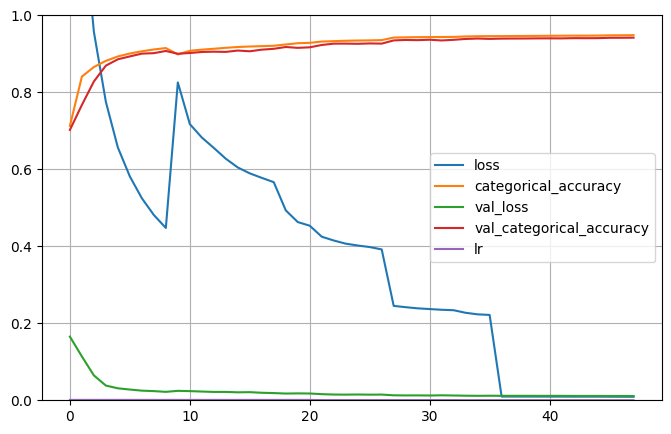

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

pd.DataFrame(history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig("/content/drive/MyDrive/Lume/road_mapper_dnn/src/results_6classes_curvegraph.png",format='png')
plt.show()

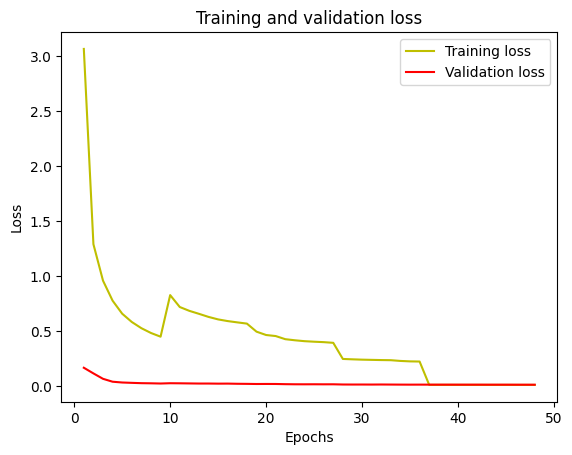

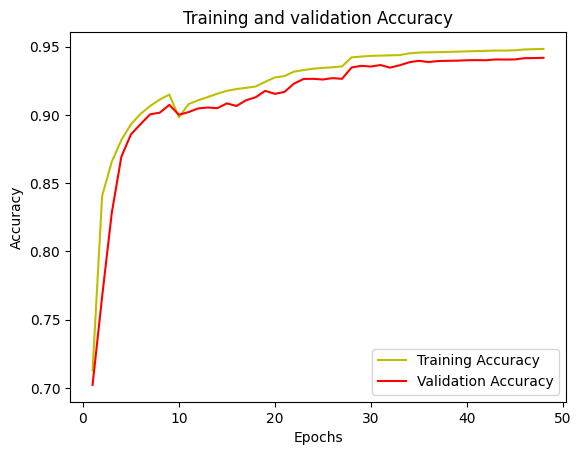

In [ ]:
from matplotlib import pyplot as plt

loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Lume/road_mapper_dnn/src/results_6classes_loss.png', format='png')
plt.show()

acc = history['categorical_accuracy']
val_acc = history['val_categorical_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/Lume/road_mapper_dnn/src/results_6classes_acc.png', format='png')
plt.show()

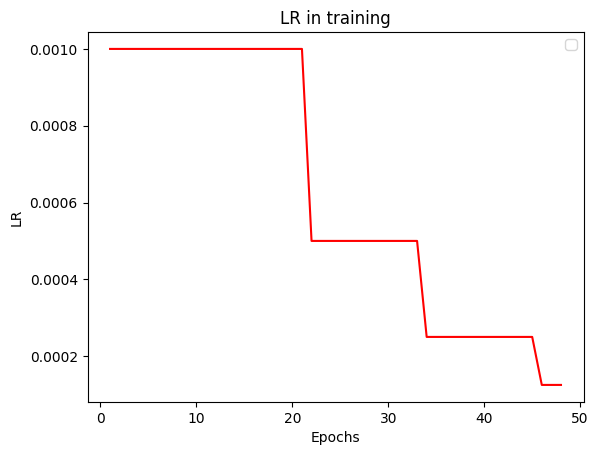

In [ ]:
lr = history['lr']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, lr, 'r')
plt.title('LR in training')
plt.xlabel('Epochs')
plt.ylabel('LR')
plt.legend()
plt.savefig('/content/drive/MyDrive/Lume/road_mapper_dnn/src/results_6classes_lr.png', format='png')
plt.show()


In [ ]:
# Load do modelo salvo
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Lume/road_mapper_dnn/T_111223_6classes/checkpoint_model_111223", compile=False)
fold = 0

## Teste e avaliação de métricas


### **Importando Bibliotecas**

In [ ]:
import datetime
from tensorflow.keras.utils import to_categorical
import numpy as np

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.metrics import mean_squared_error, balanced_accuracy_score, precision_score, recall_score, f1_score, jaccard_score

### **Importando e Tratando dados**

In [ ]:
from sklearn.preprocessing import LabelEncoder
def labelencoder(train_masks):
    labelencoder = LabelEncoder()
    n, h, w = train_masks.shape[:3]
    train_masks_reshaped = train_masks.reshape(-1,1)
    train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
    train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

#     print("encoder concluido")
#     return np.expand_dims(train_masks_encoded_original_shape, axis=3)
    return train_masks_encoded_original_shape

In [ ]:
def tocat(y, n_classes):
    train_masks_cat = to_categorical(y, num_classes=n_classes)
    return train_masks_cat.reshape((y.shape[0], y.shape[1], y.shape[2], n_classes))

In [ ]:
# Importando dados de teste
import pickle

try:
    arquivo = open("/kaggle/input/test-dataset/test_imgs.bin", "rb")
    X_test = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinox.")

try:
    arquivo = open("/kaggle/input/test-dataset/test_masks_NE.bin", "rb")
    Y_test = pickle.load(arquivo)
    arquivo.close()
except:
    print("Problemas com o arquivo treinox.")

Y_test = tocat(Y_test[:1280], 17)

In [ ]:
import json
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from keras.utils import normalize


def test_data_generator(pos_ini, mode):
  test_df = "/content/drive/MyDrive/Lume/road_mapper_dnn/dataset6classes_teste.csv"

  df = pd.read_csv(
                    test_df, skiprows=pos_ini, nrows=1)
  n_classes=6
  for i in range(0, len(df)):
      x = json.loads(df.iloc[i,0])
      y =json.loads(df.iloc[i,1])

  if mode=='x':
    x = normalize(x, axis=1)
    return np.asarray(x)
  elif mode=='y':
    return np.asarray(y)

  return None

In [ ]:
# x_test = test_data_generator(0, 'x')
# y_test = test_data_generator(0, )

### **Acurácia e F1 Score**

- **Acurácia (Accuracy)**:
   - A acurácia é uma métrica de avaliação comum em problemas de classificação.
   - Ela mede a proporção de previsões corretas feitas pelo modelo em relação ao número total de previsões.
   - A fórmula para a acurácia é: $$ \text{Acurácia} = \frac{\text{Verdadeiros Positivos} + \text{Verdadeiros Negativos}}{\text{Verdadeiros Positivos} + \text{Falsos Positivos} + \text{Verdadeiros Negativos} + \text{Falsos Negativos}} $$.
   - A acurácia é simples de entender, mas pode ser enganosa em conjuntos de dados desequilibrados, onde uma classe é muito mais comum do que outras, pois o modelo pode atingir uma alta acurácia simplesmente prevendo a classe majoritária.


        
- **F1-Score**:
   - O F1-Score é uma métrica que leva em consideração tanto a precisão quanto o recall (revocação) e é útil em problemas de classificação desequilibrados.
   - O F1-Score é a média harmônica da precisão e do recall e é calculado pela fórmula: $$ F1 = \frac{2 \times \text{Precisão} \times \text{Revocação}}{\text{Precisão} + \text{Revocação}} $$.
   - A precisão mede a proporção de previsões positivas corretas, enquanto o recall mede a capacidade do modelo de identificar todos os casos positivos.
   - O F1-Score é especialmente útil quando você deseja encontrar um equilíbrio entre a precisão e o recall, pois leva em consideração tanto os falsos positivos quanto os falsos negativos.

Em resumo, a acurácia mede a proporção de previsões corretas, enquanto o F1-Score é uma métrica que combina precisão e recall, útil em problemas de classificação desequilibrados. A escolha entre essas métricas depende do contexto e dos objetivos específicos de avaliação do seu modelo de aprendizado de máquina.

In [ ]:
accuracy_list = []
f1_list = []

In [62]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tqdm import tqdm
from scipy.special import softmax

n_classes=6
num_imgs = int(2000//4)
# num_imgs = 10
batch_size = 1
all_predict = []
all_gt = []
all_prob = []
accuracy_list = []
f1_list = []
prec_list = []
recall_list = []


for i in tqdm(range(1500, 2000), desc="Processing.."):

    # Gera os dados
    y_pred = model.predict(test_data_generator(i, 'x'), verbose=0)
    Y_test = test_data_generator(i, 'y')
    # print(test_data_generator(i, 'y'))

    # Retorna o indice de maior valor (o que refere-se ao numero da classe)
    y_pred_argmax=np.argmax(y_pred, axis=3)

    # # Salvar probabilidades
    # class_probabilities = tf.nn.softmax(y_pred, axis=-1).numpy()

    # Transforma todos os valores para inteiro
    Y_test= Y_test.astype(np.uint8)
    y_pred= y_pred_argmax.astype(np.uint8)

    # Transforma o array 3D em um array 1D
    predictions_flat = y_pred.flatten()
    y_flat = Y_test.flatten()

    # all_prob.extend(class_probabilities)
    all_predict.extend(predictions_flat)
    all_gt.extend(y_flat)

    # Calcula e salva o score
    accuracy_list.append(accuracy_score(y_flat, predictions_flat))

    f1 = f1_score(y_flat, predictions_flat, average='macro')
    f1_list.append(f1)

    prec_list.append(precision_score(y_flat, predictions_flat,average='macro'))

    recall_list.append(recall_score(y_flat, predictions_flat, average='macro'))

print('Finished!')

len(accuracy_list)

Processing..: 100%|█████████▉| 499/500 [1:00:00<00:07,  7.22s/it]


UnboundLocalError: ignored

In [63]:
medias_evaluation = {"Accuracy": [sum(accuracy_list)/len(accuracy_list)], "F1": [sum(f1_list)/len(f1_list)], "Precision": [sum(prec_list)/len(prec_list)], "Recall": [sum(recall_list)/len(recall_list)]}
pd.DataFrame(medias_evaluation, index=["KFOLD "+str(fold)])

,Accuracy,F1,Precision,Recall
KFOLD 0,0.932087,0.829203,0.832054,0.82727


In [ ]:
import pickle
try:
  with open('/content/drive/MyDrive/ROAD_MAPPER_DNN/metrics_0611.txt', 'w') as arquivo:
      # Adiciona mais conteúdo ao arquivo
        arquivo.write(str(medias_evaluation))
except:
    print("Problemas com o arquivo treino.")


### **Matriz de Confusão**
Uma matriz de confusão (confusion matrix) é uma tabela que é usada em problemas de classificação para avaliar o desempenho de um modelo de aprendizado de máquina. Ela é frequentemente usada para resumir o desempenho de um algoritmo de classificação em relação a um conjunto de dados de teste no qual os rótulos verdadeiros são conhecidos.

Uma matriz de confusão tem as seguintes quatro entradas principais:

**Verdadeiro Positivo (True Positive - TP):** Representa os casos em que o modelo classificou corretamente uma instância como positiva (classe de interesse) quando ela realmente era positiva.

**Falso Positivo (False Positive - FP):** Representa os casos em que o modelo classificou erroneamente uma instância como positiva quando na verdade era negativa (uma espécie de erro do tipo I).

**Verdadeiro Negativo (True Negative - TN):** Representa os casos em que o modelo classificou corretamente uma instância como negativa quando ela realmente era negativa.

**Falso Negativo (False Negative - FN):** Representa os casos em que o modelo classificou erroneamente uma instância como negativa quando na verdade era positiva (uma espécie de erro do tipo II).

O desempenho de um modelo de classificação pode ser avaliado examinando os valores na matriz de confusão, permitindo que você entenda como o modelo está classificando as instâncias em diferentes categorias e identifique possíveis áreas de melhoria no modelo.

In [64]:
from sklearn.metrics import confusion_matrix
cm_geral = confusion_matrix(all_gt, all_predict)


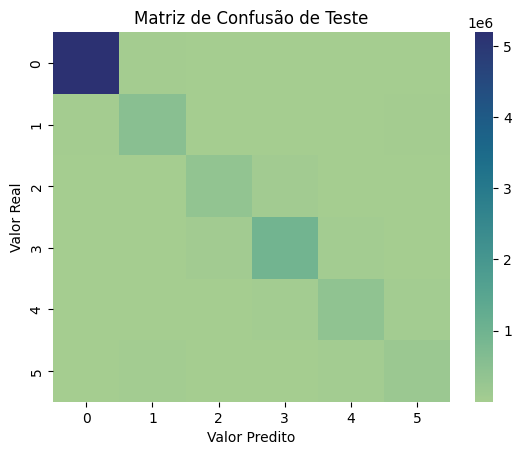

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm_geral, annot=False, fmt='d', cmap='crest')
plt.title('Matriz de Confusão de Teste')
plt.xlabel('Valor Predito')
plt.ylabel('Valor Real')
plt.savefig('kfold'+str(fold)+'_0711_mc.png', format='png')
plt.show()


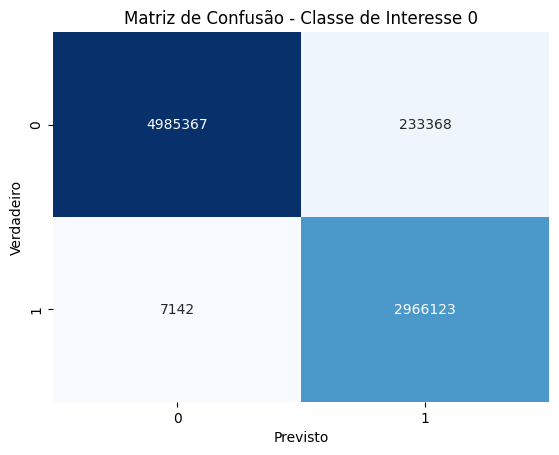

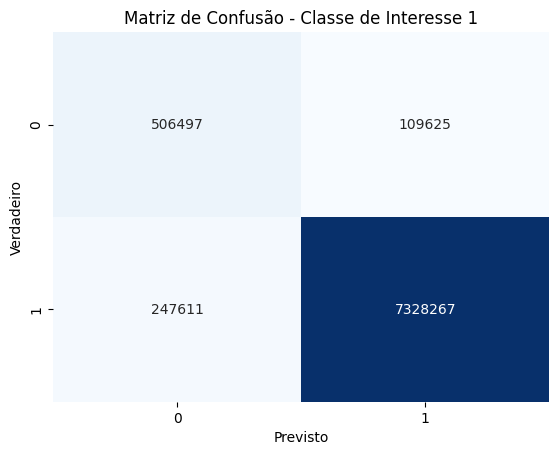

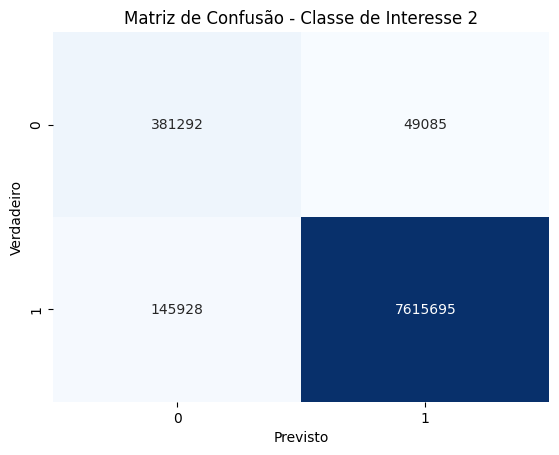

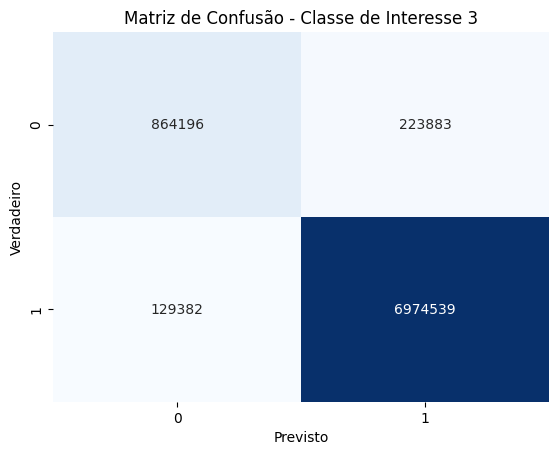

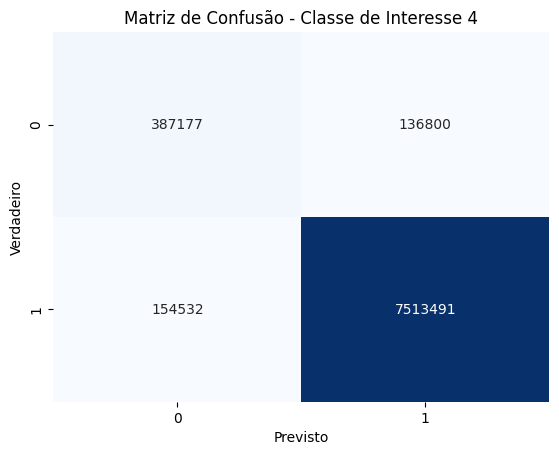

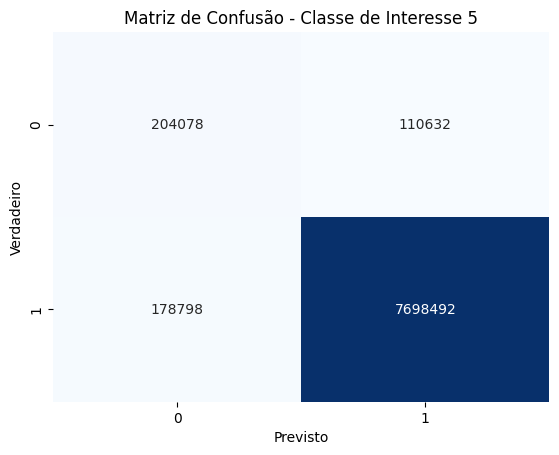

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# y_flat, predictions_flat
# Lista de classes únicas.
classes = np.unique(all_gt)
ts = 0.5

# Calcula e plota matrizes de confusão personalizadas para cada classe.
for classe_interesse in classes:
    # Inicializa a matriz de confusão personalizada.
    cm_custom = np.zeros((2, 2), dtype=int)


    for i in range(len(all_gt)):
        verdadeiro = all_gt[i]
        previsto = all_predict[i]
        # prob = all_prob[i]

        if verdadeiro == classe_interesse and previsto == classe_interesse:
            cm_custom[0, 0] += 1  # Verdadeiros positivos
        elif verdadeiro == classe_interesse and previsto != classe_interesse:
            cm_custom[0, 1] += 1  # Falsos negativos
        elif verdadeiro != classe_interesse and previsto == classe_interesse:
            cm_custom[1, 0] += 1  # Falsos positivos
        else:
            cm_custom[1, 1] += 1  # Verdadeiros negativos

    # accuracy_custom = (cm_custom[0, 0]+cm_custom[1, 1])/(cm_custom[0, 0]+cm_custom[1, 1]+cm_custom[1, 0]+cm_custom[0, 1])
    # print('accuracy_custom para a classe '+str(classe_interesse)+' :'+str(accuracy_custom))

    # Plota a matriz de confusão personalizada.
    plt.figure()
    sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusão - Classe de Interesse {classe_interesse}')
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    # plt.savefig('/content/drive/MyDrive/Lume/road_mapper_dnn/kfold_model_22_11/src/kfold'+str(fold)+'_0711_mc_classe' + str(classe_interesse) + '.png', format='png')
    plt.show()

### **IOU** - "Intersection over Union" (Interseção sobre União)
A IOU é uma medida que quantifica a sobreposição entre a caixa delimitadora (bounding box) prevista por um modelo e a caixa delimitadora verdadeira (ground truth) do objeto na imagem.

A fórmula da IOU é a seguinte:

$$IOU = \frac{Área\ da\ Interseção}{Área\ da\ União} = \frac{|T*P|}{|T+P-(T*P)|}$$

- A "Área da Interseção" é a área comum entre a caixa delimitadora prevista pelo modelo e a caixa delimitadora verdadeira.
- A "Área da União" é a área total coberta pelas duas caixas delimitadoras.

O valor da IOU varia de 0 a 1, onde 0 indica nenhuma sobreposição e 1 indica uma sobreposição perfeita. Em geral, quanto maior a IOU, melhor o desempenho da detecção de objetos. Um valor de corte (threshold) da IOU é frequentemente escolhido para determinar se uma detecção é considerada verdadeira ou falsa.

In [66]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(all_gt, all_predict)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.724648


In [ ]:
#Calculando o I0U para cada classe...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

[[5.174326e+06 3.792500e+04 1.310000e+02 8.530000e+02 6.030000e+02
  4.897000e+03]
 [3.498800e+04 5.326500e+05 2.000000e+00 5.420000e+02 4.867000e+03
  4.307300e+04]
 [2.720000e+02 5.900000e+01 3.672490e+05 6.258100e+04 1.950000e+02
  2.100000e+01]
 [8.320000e+02 5.330000e+02 7.456200e+04 9.550790e+05 5.643300e+04
  6.400000e+02]
 [8.140000e+02 4.992000e+03 1.430000e+02 6.232700e+04 4.078000e+05
  4.790100e+04]
 [8.195000e+03 5.302900e+04 2.100000e+01 1.313000e+03 5.664900e+04
  1.955030e+05]]


In [ ]:
classes_iou = {"Classes":[], "IoU": []}
for i in range(n_classes):
    class_iou = values[i,i]
    soma_iou = 0.0
    for j in range(n_classes):
        if i==j:
            soma_iou += values[i,i]
        else:
            soma_iou += values[i,j]
            soma_iou += values[j,i]

    class_iou = class_iou/soma_iou
    classes_iou["Classes"].append(i+1)
    classes_iou["IoU"].append(class_iou)

pd.DataFrame(classes_iou)

,Classes,IoU
0,1,0.982995
1,2,0.747411
2,3,0.726886
3,4,0.785624
4,5,0.634487
5,6,0.475396


In [ ]:
class_weights_iou = {}

for i in range(len(classes_iou["IoU"])):
  class_weights_iou[i] = (1-classes_iou["IoU"][i])*100

class_weights_iou

{0: 1.7901638746203208,
 1: 26.06609640709161,
 2: 29.093823049153457,
 3: 22.138270661098215,
 4: 36.90413262854398,
 5: 56.70105216005602}

## Visualizando os Resultados - Plotando imagens

In [ ]:
# Importar imagem aleatória
import random
num_imgs = 2000
test_img_number = random.randint(0, num_imgs-1)
X_test = test_data_generator(test_img_number, 'x')[0]
Y_test = test_data_generator(test_img_number, 'y')


1/1 [==============================] - 0s 62ms/step


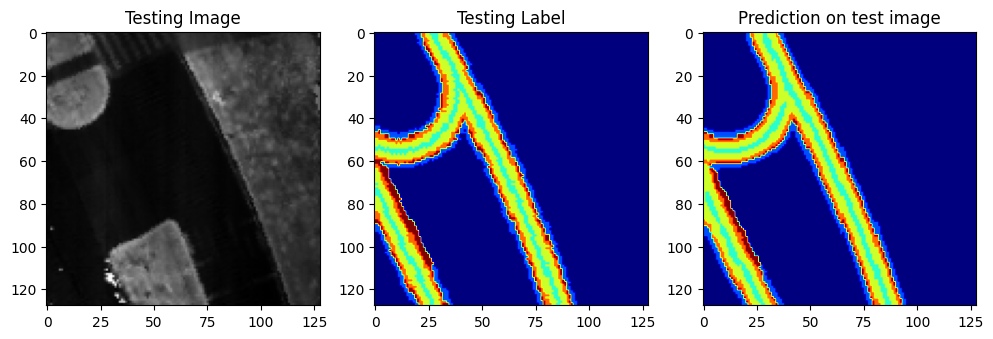

In [ ]:
import random
import matplotlib.pyplot as plt
test_img = X_test
ground_truth=Y_test
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.savefig('/content/drive/MyDrive/Lume/road_mapper_dnn/src/saida'+str(test_img_number), format='png')
plt.show()